# Return Order Agent

## Imports

In [9]:
# Core libraries
import os
import json
import sqlite3
import pandas as pd

# OpenAI client
from openai import OpenAI



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Program Files\Anaconda\envs\LangChain\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Program Files\Anaconda\envs\LangChain\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Program Files\Anaconda\envs\LangChain\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start(

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Program Files\Anaconda\envs\LangChain\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Program Files\Anaconda\envs\LangChain\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Program Files\Anaconda\envs\LangChain\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start(

AttributeError: _ARRAY_API not found

## Tools

In [10]:
class PDFRetrieverTool:
    def __init__(self, content):
        self.content = content

    def run(self, query: str):
        if "return" in query.lower() or "refund" in query.lower():
            return self.content
        return "No relevant policy found in the PDF."


class DatabaseQueryTool:
    def __init__(self, db):
        self.db = db

    def run(self, query: str):
        """Execute an SQL query safely and return results as dictionaries."""
        try:
            result = self.db.run(query)
            
            # If the result is a string (some SQLDatabase backends return strings)
            if isinstance(result, str):
                import io
                return pd.read_csv(io.StringIO(result)).to_dict(orient="records")

            # Otherwise, assume it's a DataFrame
            return result.to_dict(orient="records")
        
        except Exception as e:
            return {"error": f"Error executing query: {e}"}


## Agent

In [11]:
class AutonomousReturnAgent:
    def __init__(self, llm_client, tools: dict):
        self.client = llm_client
        self.tools = tools
        self.memory = []

    def build_prompt(self, user_message):
        memory_text = "\n".join([f"{m['role'].capitalize()}: {m['content']}" for m in self.memory])
        return f"""
You are an autonomous customer service AI for Polar, a retail brand.
You can use the following tools when needed:

Tools available:
- pdf_tool: retrieves text from policy PDF.
- db_tool: queries customer and order database using SQL.

Your task is to assist with questions about orders, returns, and refunds.
You decide which tool to call and what SQL or query to run.
Always explain your reasoning and results clearly.

Conversation so far:
{memory_text}

User: {user_message}
If you need to use a tool, respond in JSON with the format:
{{"action": "tool_name", "input": "your query"}}
Otherwise, reply with the final message to the user.
"""

    def process(self, user_message):
        # Append user message to memory
        self.memory.append({"role": "user", "content": user_message})

        # Build reasoning prompt
        prompt = self.build_prompt(user_message)

        # Step 1: Ask LLM what to do
        response = self.client.chat.completions.create(
            model="gpt-5",
            messages=[{"role": "system", "content": "You are a helpful AI agent."},
                      {"role": "user", "content": prompt}]
        )
        message = response.choices[0].message.content.strip()
        print(f"🧰 LLM reasoning message: {message}")

        # Step 2: If the message looks like a tool call
        try:
            parsed = json.loads(message)
            if "action" in parsed:
                tool_name = parsed["action"]
                tool_input = parsed["input"]
                print(f"🧰 Using tool: {tool_name} → {tool_input}")

                if tool_name not in self.tools:
                    result = f"Unknown tool: {tool_name}"
                else:
                    result = self.tools[tool_name].run(tool_input)

                self.memory.append({"role": "tool", "content": str(result)})
                print(f"🧰 Tool result: {result}")

                # Ask LLM to summarize tool result for the user
                follow_up = self.client.chat.completions.create(
                    model="gpt-5",
                    messages=[
                        {"role": "system", "content": "You are a customer service AI assistant."},
                        {"role": "user", "content": f"The tool returned this: {result}. Summarize or continue the answer to the user clearly."}
                    ]
                )
                final_message = follow_up.choices[0].message.content.strip()
                self.memory.append({"role": "assistant", "content": final_message})
                print(f"🧰 Final message:")
                return final_message
        except Exception:
            print(f"🧰 Exception")
            pass  # not JSON, continue as normal text

        # Step 3: Otherwise, it’s a normal reply
        self.memory.append({"role": "assistant", "content": message})
        print(f"🧰 Final message:")
        return message


## Chat

In [12]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "../docs/polar-return-policy.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

pdf_text = ""
for doc in docs:
    pdf_text += doc.page_content

print(pdf_text)

POLÍTICA DE TROCAS E DEVOLUÇÃO 
A Loja Virtual POLAR deseja sua total satisfação ao realizar suas compras. Neste sentido, criamos uma Política 
de Troca e Devolução respeitando às suas necessidades e baseada no Código de Defesa do Consumidor  
(http://www.idec.org.br/consultas/codigo-de-defesa-do-consumidor). As presentes condições de compra e venda 
são as cláusulas de contratação por adesão que você, consumidor, assume ao efetuar uma compra na Loja 
Virtual POLAR . 
Antes de qualquer procedimento , a troca ou devolução de qualquer produto precisa ser informada ao nosso 
Atendimento ao Cliente pelo telefone (11) 4935-2354, das 9h ás 18h, ou por e-mail lojavirtual@polar.com. 
DICAS IMPORTANTES 
Só serão aceitos produtos: não lavados, não usados, sem odores, que não tenham sido alterados, intactos, com 
as etiquetas originais e com sua embalagem original. Todo produto devolvido deverá vir acompanhado da Nota 
Fiscal, com as seguintes informações preenchidas no verso: 
Nome completo; 
En

In [13]:
from langchain_community.utilities import SQLDatabase

local_db_path = "../datasets/olist_ecommerce.db"
db = SQLDatabase.from_uri(f"sqlite:///{local_db_path}")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM customers LIMIT 5;")}')

Dialect: sqlite
Available tables: ['category_translation', 'customers', 'geolocation', 'order_items', 'order_payments', 'order_reviews', 'orders', 'products', 'sellers']
Sample output: [('06b8999e2fba1a1fbc88172c00ba8bc7', '861eff4711a542e4b93843c6dd7febb0', 14409, 'franca', 'SP'), ('18955e83d337fd6b2def6b18a428ac77', '290c77bc529b7ac935b93aa66c333dc3', 9790, 'sao bernardo do campo', 'SP'), ('4e7b3e00288586ebd08712fdd0374a03', '060e732b5b29e8181a18229c7b0b2b5e', 1151, 'sao paulo', 'SP'), ('b2b6027bc5c5109e529d4dc6358b12c3', '259dac757896d24d7702b9acbbff3f3c', 8775, 'mogi das cruzes', 'SP'), ('4f2d8ab171c80ec8364f7c12e35b23ad', '345ecd01c38d18a9036ed96c73b8d066', 13056, 'campinas', 'SP')]


In [14]:
pdf_tool = PDFRetrieverTool(pdf_text)
db_tool = DatabaseQueryTool(db)
client = OpenAI()

agent = AutonomousReturnAgent(
    llm_client=client,
    tools={"pdf_tool": pdf_tool, "db_tool": db_tool}
)


In [15]:
# print(agent.process("Hi! I want to know how the return policy works."))

In [16]:
# print(agent.process("Can you check if order e481f51cbdc54678b7cc49136f2d6af7 is eligible for a return?"))


In [17]:
# print(agent.process("What is customer id for order 6514b8ad8028c9f2cc2374ded245783f ?"))


# New Agent

## SQL Toolkit

In [175]:
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase

In [176]:
local_db_path = "../datasets/olist_ecommerce.db"

In [177]:
db = SQLDatabase.from_uri(f"sqlite:///{local_db_path}")

In [178]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0)

In [179]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [180]:
sql_toolkit.get_tools()

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001FC35E53A10>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001FC35E53A10>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001FC35E53A10>),
 QuerySQLCheckerTool(description='Use this tool to 

In [181]:
from langchain_classic import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
print(prompt_template.input_variables)

['dialect', 'top_k']


In [182]:
system_template = prompt_template.messages[0].prompt.template
print(system_template)


You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see 

In [183]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [184]:
print(system_message)

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see w

In [185]:
sql_tools = sql_toolkit.get_tools()

In [186]:
from langchain.agents import create_agent

sql_agent = create_agent(llm, sql_tools, system_prompt=system_message)

In [30]:
example_query = "What is customer id for order 6514b8ad8028c9f2cc2374ded245783f ?"

events = sql_agent.stream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is customer id for order 6514b8ad8028c9f2cc2374ded245783f ?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_Ave1jbrHKLcgpBW2IekAIkYt)
 Call ID: call_Ave1jbrHKLcgpBW2IekAIkYt
  Args:
    query: SELECT customer_id FROM orders WHERE order_id = '6514b8ad8028c9f2cc2374ded245783f'
================================= Tool Message =================================
Name: sql_db_query

[('9bdf08b4b3b52b5526ff42d37d47f222',)]
================================== Ai Message ==================================

The customer id for the order with order_id '6514b8ad8028c9f2cc2374ded245783f' is '9bdf08b4b3b52b5526ff42d37d47f222'.


## PDF Tool

In [31]:
RETURN_POLICY_PATH = "../docs/polar-return-policy.pdf"

In [187]:
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import MessagesState

def pdf_branch(state: MessagesState) -> MessagesState:
    print("Running PDF branch...")
    loader = PyPDFLoader("../docs/polar-return-policy.pdf")
    docs = loader.load()
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in docs
    )

    # store the serialized PDF content in the state
    state["pdf_context"] = serialized
    return state


In [120]:
from langchain.chat_models import init_chat_model

llm_model = init_chat_model("openai:gpt-5")

In [ ]:
from langchain.agents import create_agent


tools = [pdf_branch]
prompt = (
    "You have access to a tool that retrieves a PDF file containing the return policy. "
    "Use the tool to help answer user queries."
)
pdf_agent = create_agent(llm_model, tools, system_prompt=prompt)

In [122]:
query = ("Hi! I want to know how the return policy works.")

for event in pdf_agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I want to know how the return policy works.
================================== Ai Message ==================================
Tool Calls:
  load_pdf (call_kbHgsbXF8AoE25K6oWv9uAxI)
 Call ID: call_kbHgsbXF8AoE25K6oWv9uAxI
  Args:
================================= Tool Message =================================
Name: load_pdf

{"pdf_content": "Source: {'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2016-11-21T09:53:24+02:00', 'author': 'Tiago Lisboa', 'moddate': '2016-11-21T09:53:24+02:00', 'source': '../docs/polar-return-policy.pdf', 'total_pages': 3, 'page': 0, 'page_label': '1'}\nContent: POLÍTICA DE TROCAS E DEVOLUÇÃO \nA Loja Virtual POLAR deseja sua total satisfação ao realizar suas compras. Neste sentido, criamos uma Política \nde Troca e Devolução respeitando às suas necessidades e baseada no Código de Defesa do Consumidor  \n(http://www.idec.org.br/consult

## Agent

In [237]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [221]:
from typing import List, Dict, Any, TypedDict

# --- Define a message structure ---
class Message(TypedDict, total=False):
    role: str               # "user", "assistant", "system"
    content: str
    tool_calls: List[Any]   # optional, stores tool call results

# --- Define the agent's state ---
class MessagesState(TypedDict, total=False):
    messages: List[Message]          # all messages so far
    decision: str                    # output of decide_path node
    pdf_content: str                 # output of load_pdf node
    sql_result: Any                  # output of run_query_node
    last_query: str                  # optional: last generated SQL query
    schema_info: Dict[str, Any]      # optional: schema from get_schema_node


In [238]:
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import MessagesState

def pdf_branch(state: MessagesState) -> MessagesState:
    print("Running PDF branch...")
    loader = PyPDFLoader("../docs/polar-return-policy.pdf")
    docs = loader.load()
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in docs
    )

    # store the serialized PDF content in the state
    state["pdf_context"] = serialized
    print(f"pdf_context: {state['pdf_context']}")
    return state


In [239]:
# Steps
from typing import Literal

from langgraph.prebuilt import ToolNode
from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph


get_schema_tool = next(tool for tool in sql_tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in sql_tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    print("list_tables tool")
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in sql_tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    print("call_get_schema tool")
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    print("generate_query tool")
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    print("check_query tool")
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [240]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

llm_answer = ChatOpenAI(model="gpt-5", temperature=0)

def answer_node(state: MessagesState) -> MessagesState:
    print("Generating final answer...")
    messages = state["messages"]
    user_question = messages[-1].content
    pdf_context = state.get("pdf_context", "")

    system_prompt = "Responda à pergunta do usuário. Use o contexto do PDF se fornecido."

    if pdf_context:
        system_prompt += f"\n\nContexto do PDF:\n{pdf_context}"

    response = llm_answer.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ])

    # Append the model's answer to the conversation
    state["messages"].append(response)
    return state


In [241]:
from typing import Literal
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI


llm_router = ChatOpenAI(model="gpt-5", temperature=0)

def decide_path(state: MessagesState) -> Literal["sql_branch", "pdf_branch", "pdf_sql_branch", "general"]:
    print("decide_path tool")
    messages = state["messages"]
    user_message = messages[-1].content

    system_prompt = (
        "Você é um router que decide quais tools são necessárias para responder à pergunta do usuário.\n"
        "Saídas possíveis:\n"
        "- 'sql_branch': a pergunta necessita apenas do banco de dados.\n"
        "- 'pdf_branch': a pergunta necessita apenas do PDF.\n"
        "- 'pdf_sql_branch': a pergunta necessita tanto do banco de dados quanto do PDF.\n"
        "- 'general': nenhuma ferramenta necessária.\n\n"
        "Exemplos:\n"
        "- 'Quais clientes pediram mais de 5 itens?' → sql_branch\n"
        "- 'Qual é a política de devolução?' → pdf_branch\n"
        "- 'O pedido e481f51... é elegível para devolução de acordo com a política?' → pdf_sql_branch\n"
        "- 'Quem é você?' → general"
    )

    response = llm_router.invoke([SystemMessage(content=system_prompt)] + messages)
    print(f"decision response: {response}")
    decision = response.content.strip().lower()

    if decision not in {"sql_branch", "pdf_branch", "pdf_sql_branch", "general"}:
        decision = "general"
    print(f"decision: {decision}")
    return {"decide_path": decision}



In [243]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    print("should_continue")
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)

# Add all nodes
builder.add_node("decide_path", decide_path)
builder.add_node("pdf_branch", pdf_branch)
builder.add_node("list_tables", list_tables)
builder.add_node("call_get_schema", call_get_schema)
builder.add_node("get_schema", get_schema_node)
builder.add_node("generate_query", generate_query)
builder.add_node("check_query", check_query)
builder.add_node("run_query", run_query_node)

# Optional: a final answer node that uses PDF/SQL context to respond
builder.add_node("answer", answer_node)

# Add routing edges
builder.add_edge(START, "decide_path")

builder.add_conditional_edges(
    "decide_path",
    lambda state: state["decide_path"],
    {
        "sql_branch": "list_tables",
        "pdf_branch": "pdf_branch",
        "pdf_sql_branch": "pdf_branch",  # then we’ll chain SQL after PDF
        "general": "answer",
    }
)

# --- PDF path ---
# After loading PDF, go either to SQL or directly to answer
builder.add_conditional_edges(
    "pdf_branch",
    lambda state: (
        "list_tables" if state["pdf_context"] == "pdf_sql_branch" else "answer"
    ),
    {
        "list_tables": "list_tables",
        "answer": "answer",
    },
)

# Keep your SQL workflow as before
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges("generate_query", should_continue)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

# End of pipeline
builder.add_edge("answer", END)

agent = builder.compile()

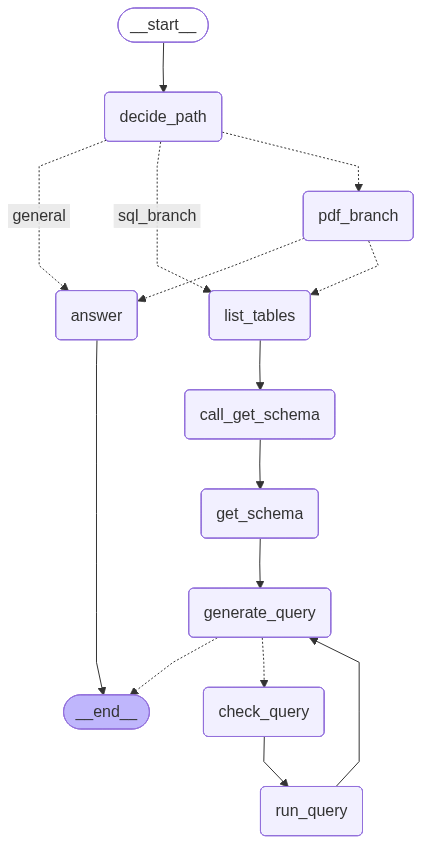

In [244]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [245]:
example_query

'Olá quero saber como funciona a politica de devolucao'

In [246]:
pdf_query = "Olá quero saber como funciona a politica de devolucao"
sql_query = "Qual o id do cliente para o pedido 6514b8ad8028c9f2cc2374ded245783f ?"
pdf_sql_query = "Você pode checar se o pedido e481f51cbdc54678b7cc49136f2d6af7 é elegivel para devolucao?"


In [251]:
example_query = pdf_sql_query

In [252]:
for step in agent.stream(
    {"messages": [{"role": "user", "content": example_query}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Você pode checar se o pedido e481f51cbdc54678b7cc49136f2d6af7 é elegivel para devolucao?
decide_path tool
decision response: content='pdf_sql_branch' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 186, 'total_tokens': 326, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CW70YLuOFeucbPRYDaSiHHamOu6vS', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--40344826-b23a-40ac-8524-c7d2337a9b79-0' usage_metadata={'input_tokens': 186, 'output_tokens': 140, 'total_tokens': 326, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'